In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import enviroment_no_visual as enviroment

Funzioni per inizializzare e accedere la tabella dei Q-Values

In [2]:
def state_to_index(state_vector):    
    # 3 bit con 8 possibili pericoli 
    pericoli = state_vector[0] * 4 + state_vector[1] * 2 + state_vector[2]  
    # 4 bit ma solo 4 direzioni corrente
    direzione_corrente = state_vector[3] * 3 + state_vector[4] * 2 + state_vector[5] * 1
    # 4 bit ma solo 8 posizioni frutto
    posizione_frutto = np.mod(state_vector[7] * 6 + state_vector[8] * 3 + state_vector[9] * 2 + state_vector[10], 8)
    return pericoli * 32 + direzione_corrente * 8 + posizione_frutto

def initialize_QTable():
    return np.zeros((256, 3))

Exploration policies

In [3]:
def random_policy():
    return np.random.randint(3)

def epsilon_greedy_policy(Q_table, state, epsilon):
    if random.uniform(0,1) < epsilon:
        return np.random.randint(3)
    else:
        row_Q_value = state_to_index(state)
        return np.argmax(Q_table[row_Q_value])

def exploration_function_policy(Q_table, N_table, state, k):
    row_Q_value = state_to_index(state)
    exploration_values = Q_table[row_Q_value] + k / (1 + N_table[row_Q_value])
    return np.argmax(exploration_values)
def update_N_table(N_table, state, action):
    row_N_value = state_to_index(state)
    N_table[row_N_value][action] += 1

def optimal_policy(Q_table, state):
    row_Q_value = state_to_index(state)
    return np.argmax(Q_table[row_Q_value])


Esegue una mossa nel gioco

In [4]:
def step(env, action):
    final_move = [0,0,0]
    final_move[action] = 1
    new_state, reward, game_over, _ = env.play_step(final_move)
    return new_state, reward, game_over

Funzione per allenare l'Agente.

Ogni 10_000 step la tabella è salvata nella cartella della corrispettiva funzione di esplorazione scelta.

In [5]:
def trainAgent(POLICY_NAME, lr, gamma, N_STEPS):
    env = enviroment.SnakeGameAI()
    Q_table = initialize_QTable()
    if POLICY_NAME == "ExplorationFunction":
        N_table = initialize_QTable()
    epsilon = 1
    for iteration in range(N_STEPS+1):
        state = env.get_state()
        row_state = state_to_index(state)
        
        # exploration policies
        if POLICY_NAME == "RandomPolicy":
            action = random_policy()
        elif POLICY_NAME == "ExplorationFunction":
            action = exploration_function_policy(Q_table, N_table, state, k=100)
            update_N_table(N_table, state, action)
        elif POLICY_NAME == "Optimally":
            action = optimal_policy(Q_table, state)
        else:
            action = epsilon_greedy_policy(Q_table, state, epsilon)
            epsilon = max((N_STEPS - iteration)/(N_STEPS), 0.1)

        next_state, reward, game_over = step(env, action)
        row_next_state = state_to_index(next_state)
        next_value = Q_table[row_next_state].max()  
        # Equazione di Bellman
        Q_table[row_state, action] *= 1 - lr
        Q_table[row_state, action] += lr * (reward + gamma * next_value)
        if game_over:
            env.reset()
        if (iteration % 10_000 == 0) and (iteration != 0):
            np.save(f'Q_table/{POLICY_NAME}/{iteration}step.npy', Q_table)
            print(f"\rNumero step eseguiti: {iteration}\\{N_STEPS}", end="")

In [6]:
print("Training con RandomPolicy")
trainAgent("RandomPolicy", lr = 0.05, gamma = 0.9, N_STEPS = 1_000_000)
print("\nTraining con policy EpsilonGreedyLineare")
trainAgent("EpsilonGreedyLineare", lr = 0.05, gamma = 0.9, N_STEPS = 1_000_000)
print("\nTraining con policy ExplorationFunction")
trainAgent("ExplorationFunction", lr = 0.05, gamma = 0.9, N_STEPS = 1_000_000)
print("\nTraining con policy Q-Value attuale maggiore")
trainAgent("Optimally", lr = 0.05, gamma = 0.9, N_STEPS = 1_000_000)

Training con RandomPolicy


Numero step eseguiti: 1000000\1000000
Training con policy EpsilonGreedyLineare
Numero step eseguiti: 1000000\1000000
Training con policy ExplorationFunction
Numero step eseguiti: 1000000\1000000
Training con policy Q-Value attuale maggiore
Numero step eseguiti: 1000000\1000000

Funzione per far giocare l'Agente allenato scelto tramite policy ottimale, ovvero scegliendo il Q-Value maggiore per stato quindi l'azione che ci si aspetta porti alla ricompensa. Il numero di partite giocate è determinato da MAX_N_GAMES ed è restituita la media dello score delle partite giocate, il massimo score, e la standard deviation.

In [7]:
def play_N_games_optimally(Q_table, MAX_N_GAMES):
    env = enviroment.SnakeGameAI()
    score_list = []
    for _ in range(MAX_N_GAMES):
        env.reset()
        game_over = False
        while not game_over:
            state= env.get_state()
            row_Q_value = state_to_index(state)
            action = np.argmax(Q_table[row_Q_value])
            final_move = [0,0,0]
            final_move[action] = 1
            _, _, game_over, score = env.play_step(final_move)
        score_list.append(score)

    mean_score = np.mean(score_list)
    max_score = max(score_list)
    standard_deviation = np.std(score_list)
    return mean_score, max_score, standard_deviation

Funzione che fa giocare tutti i modelli salvati in una directory un numero di volte pari a MAX_N_GAMES. Restituisce una lista di tuple che rappresenta per ciascuna tabella di Q-Value lo score medio, lo score massimo e la standard deviation.

In [8]:
def exploration_policy_trend(directory, MAX_N_GAMES):
    result = []
    # Ordino i files per data di creazione 
    files = sorted(
    [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))],
    key=lambda f: os.path.getmtime(os.path.join(directory, f))
)
    for filename in files:
        file_path = os.path.join(directory, filename)
        
        if os.path.isfile(file_path):
            Q_table = np.load(file_path)
            mean_score, max_score, standard_deviation = play_N_games_optimally(Q_table, MAX_N_GAMES)
            result.append((mean_score, max_score, standard_deviation))
    return result

Plot the trand for exploration policy

In [9]:
def plot_trand(result_data, training_policy_name, save_path=None):
    mean_score, max_score, standard_deviation = zip(*result_data)
    indices = [i * 10000 for i in range(len(result_data))]

    plt.plot(indices, mean_score, label='Mean Score')
    plt.plot(indices, max_score, linestyle='--', label='Max Score')
    plt.plot(indices, standard_deviation, linestyle='--', label='Standard Deviation')
    plt.title(f"Risultati ottenuti con esplorazione {training_policy_name} nel training")
    plt.xlabel("Steps")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)

    if save_path is not None:
        plt.savefig(save_path)
    
    plt.show()

Fai giocare ciascun modello salvato per 50 partite e mostra le performance per exploration policy al variare di step per training

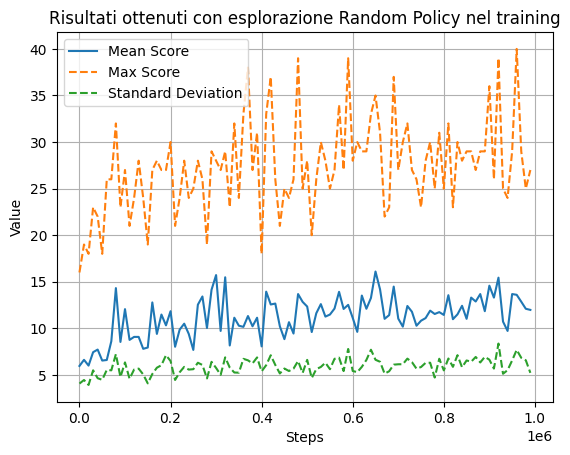

In [10]:
directory = 'Q_table/RandomPolicy'
result_random_p = exploration_policy_trend(directory, MAX_N_GAMES=50)  
plot_trand(result_random_p, "Random Policy")

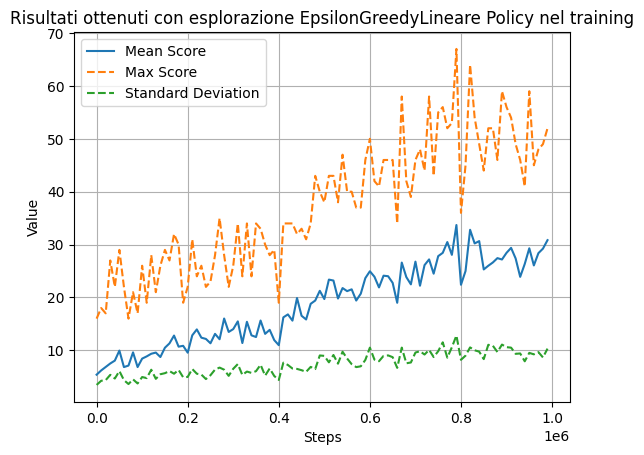

In [11]:
directory = 'Q_table/EpsilonGreedyLineare/'
EpsilonGreedyLineare_p = exploration_policy_trend(directory, MAX_N_GAMES=50)  
plot_trand(EpsilonGreedyLineare_p, "EpsilonGreedyLineare Policy")

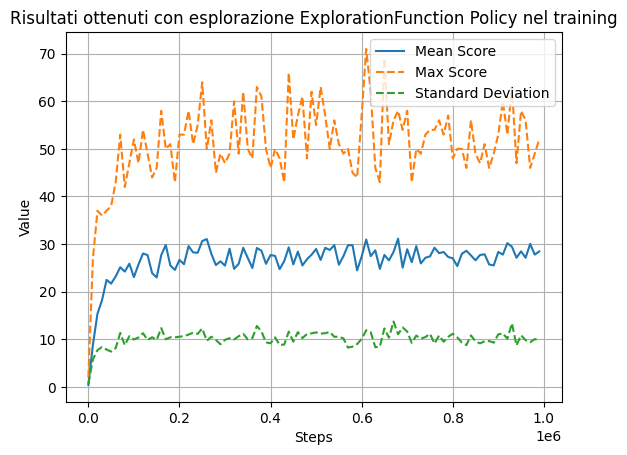

In [12]:
directory = 'Q_table/ExplorationFunction'
ExplorationFunction_p = exploration_policy_trend(directory, MAX_N_GAMES=50)
plot_trand(ExplorationFunction_p, "ExplorationFunction Policy")

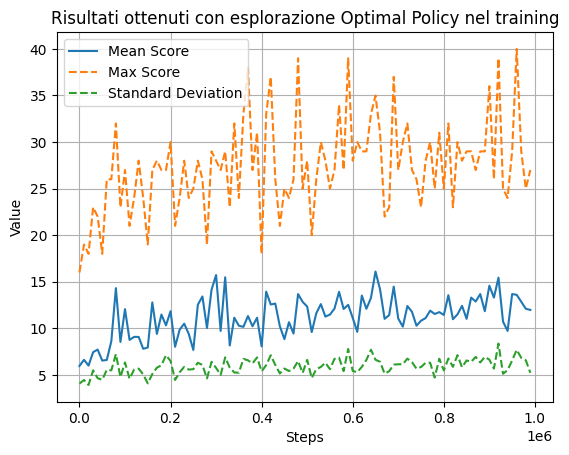

In [13]:
directory = 'Q_table/Optimally'
result_optimal_p = exploration_policy_trend(directory, MAX_N_GAMES=50)  
plot_trand(result_random_p, "Optimal Policy")

Esecuzione con visuale della policy ottimale imparata 

In [ ]:
import enviroment_visual as enviroment_visual
Q_table = np.load('Q_table/ExplorationFunction/1000000step.npy')
env_visual = enviroment_visual.SnakeGameAI()
env_visual.reset()
game_over = False
while not game_over:
    state= env_visual.get_state()
    row_Q_value = state_to_index(state)
    action = np.argmax(Q_table[row_Q_value])
    final_move = [0,0,0]
    final_move[action] = 1
    new_state, reward, game_over, score = env_visual.play_step(final_move)
    
env_visual.quit()
print(f"Score: {score}", end="")

# Sezione dedicata all'analisi delle performance al variare di k

In [ ]:
best = [0]
explore = [0]
def exploration_function_policy(Q_table, N_table, state, k):
    k=10000
    row_Q_value = state_to_index(state)
    exploration_values = Q_table[row_Q_value] + k / (1 + N_table[row_Q_value])
    if np.argmax(Q_table[row_Q_value]) == np.argmax(exploration_values):
        best[0] += 1
    else:
        explore[0] += 1
    return np.argmax(exploration_values)

Training con policy ExplorationFunction
Numero step eseguiti: 1000000\1000000

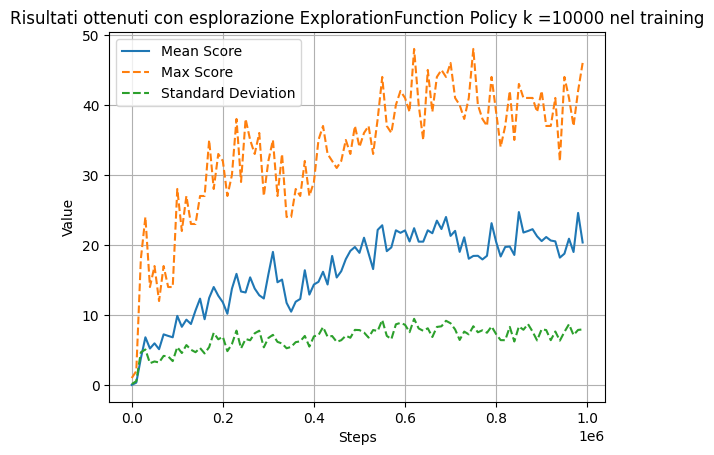

In [64]:
print("Training con policy ExplorationFunction")
trainAgent("ExplorationFunction", lr = 0.05, gamma = 0.9, N_STEPS = 1_000_000)
directory = 'Q_table/ExplorationFunction'
ExplorationFunction_p = exploration_policy_trend(directory, MAX_N_GAMES=50)
plot_trand(ExplorationFunction_p, "ExplorationFunction Policy k =10000")

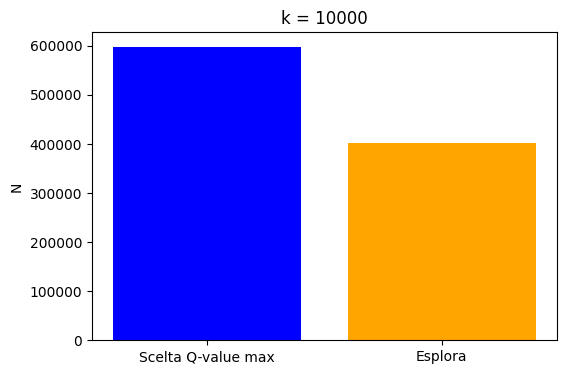

In [65]:

def grafico_differenza_altezza(num1, num2):
    etichette = ['Scelta Q-value max', 'Esplora']
    altezze = [num1, num2]
    plt.figure(figsize=(6, 4))
    plt.bar(etichette, altezze, color=['blue', 'orange'])
    plt.title('k = 10000')
    plt.ylabel('N')
    plt.show()

grafico_differenza_altezza(best[0], explore[0])